In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:10% !important;height:20% !important;}</style>"
HTML(style)

In [3]:
titanic_data = pd.read_csv("https://raw.githubusercontent.com/avynychenko/ML-course-Python/master/Datasets%20for%20ML%20course/Titanic%20Data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Далее стоит посмотреть **сколько пропущенных значений имеется в колонках** - если их много, скорее всего от данной переменной можно отказаться.

In [4]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Далее оставим только те переменные, которые нам нужны для предсказания. Удаляем:
- *'PassengerId', 'Name', 'Ticket'* - потому что они уникальные для каждого человека и вряд ли они нам нужны для предсказания
- *'Survived'* - потому что это та переменная, которую нужно предсказывать
- *'Cabin'* - потому что в ней много пропущенных значений


***В переменную Х сохраняем данных, которые нам нужны для предсказания, а в переменную У - переменную ,которую будем предсказывать.***

In [5]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
Y = titanic_data.Survived

Дерево решений может работать только с числовым интерпретатором данных, т.е. даже номинативные переменные должны быть конвертированы в числовые (например, female в 1, male в 0). Или возможно даже проще **использовать DUMMY-VARIABLES, когда номинативные переменные разбиваются на разные колонки и там, где есть нужное значение отмечается 1, в остальные - 0.** Сейчас будет пример:

In [7]:
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


**НЕДОСТАТКОМ ДЕРЕВА РЕШЕНИЙ** является то, что оно не умеет работать с пропущенными значениями. Т.е. перед тем как применить классификатор к данным, нужно заполнить пропущенные значения медианными значениям, чем и сейчас займемся: (*Это самое простое, можно было например намайнить нужные значения обучив другую модель, можно было для женщин заменить медианным значением для женщин, для мужчин соответственно их значением, т.е. вариантов много*)

In [8]:
X = X.fillna({'Age': X.Age.median()})
X.isna().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

    Создаем классификатор дерева решений и обучаем его:

In [9]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X),
                                   class_names=['Died','Survived'],
                                   filled = True))

display(SVG(graph.pipe(format='svg')))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

    Данное дерево решений ПЕРЕОБУЧИЛОСЬ, т.е. так как мы задачу поставили класифицировать данные до выживет/не выживет, то и дерево решений не остановится пока точно со 100% уверенностью не классифицирует всех пассажиров. Т.е. у данной задачи не стояло целью вычленить какие-то общие закономерности в данных, а разбить пассажиров таким образом, чтобы это было максимально точно! Что оно и сделало.

***ОПИСАНИЕ КОНЦЕПЦИИ ДЕРЕВА РЕШЕНИЙ*** Т.е. каким образом работает дерево решений: есть одна зависимая переменная и набор фичей, дерево решений на первом шаге перебирает все возможные сплиты по всем фичам и по всем его значениям (если переменная непрерывная - будет перебирать каждое значение) и выберет для первого сплита тот сплит, где INFORMATION GAIN был наибольший (т.е. где наибольше снизился уровень энтропии). И так далее дерево решений на каждом этапе будет перебирать все значения и брать те, где будет получаться максимальный INFORMATION GAIN. И так будет делать, пока все не поделит.


**ПРОБЛЕМА ПЕРЕОБУЧЕНИЯ** ***когда мы вместо того, чтобы вычленить какую-то закономерность в данных, пытаемся безошибочно классифицировать данный набор данных и в итоге получается что данное предсказание будет точно работать на предоставленных данных, но гораздо хуже справляться с новым набором данных.***

***Чтобы справится с проблемой переобучения,*** можно варьировать параметры модели дерева решений. Одним из таких параметров, который безболезненно можно применить - это ограничить глубину дерева решений. Т.е если мы поставим максимальную глубину = 5, то дерево решений сможет задать только 5 наиболее эффективных вопросов.

Функция **train_test_split( )** позволит нам просплитить наши данные в пропорции 33/67%% на тест/трейн выборки

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
6,1,54.0,0,0,51.8625,0,1,0,0,1
718,3,28.0,0,0,15.5000,0,1,0,1,0
685,2,25.0,1,2,41.5792,0,1,1,0,0
73,3,26.0,1,0,14.4542,0,1,1,0,0
882,3,22.0,0,0,10.5167,1,0,0,0,1


Т.к. мы видим, что дерево большое и глубокое - нужно проверить не переобучилось ли оно, а может просто алгоритм выживаемости на Титанике настолько сложный, что предсказать его меньшим деревом просто невозможно. Для этого мы еще раз разбили нашу трейновую выборку на 67/33 %% (шаг выше) чтобы обучить нашу модель на 67% данных, проверить точность предсказания, а потом подставить 33% данные и оценить точность предсказания там. Сделаем это:

**clf.score( )** позволяет оценить точность правильного предсказания

In [12]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
clf.score(X_train, y_train)

0.9798657718120806

In [14]:
clf.score(X_test, y_test)

0.7762711864406779

    Т.е. мы видим, что точность предсказания на трейновой выборке 97%, а на тестовой 78%, что говорит о том, что    возможно модель переобучилась
    
    Мы можем добавить параметр max_depth = какому-то число и проверим точность.

In [15]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.8338926174496645

In [16]:
clf.score(X_test, y_test)

0.823728813559322

Видим, что точность на трейновой выборке уменьшилась, но увеличилась на тестовой. ***Чтобы посмотреть как разные параметры глубины дерева влияют на модель, запишем это все в цикл***

In [17]:
max_depth_value = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [18]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


Чтобы удобно было визуализировать полученные результаты, сгруппированные по переменной это train_score или test_score, можно преобразовать таблицу с помощью функции **pd.melt( )**

In [19]:
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score', 'test_score'], 
                          var_name="set_type", value_name = "score")
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


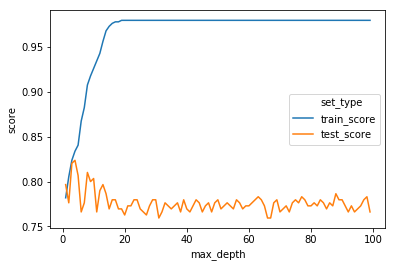

In [20]:
sns.lineplot(x="max_depth", y = "score", hue = "set_type", data = scores_data_long)

**Избегание проблемы переобучения - КРОССВАЛИДАЦИЯ!**

***Какая концепция:***
- мы сплитим все данные на тестовую и трейновую выборки. Тестовую выборку мы не трогаем, ничего на ней не проверим. Она нужна на самом финальном этапе, когда мы уже несколько раз проверили нашу модель и решили, что она самая лучшая и только потом показываем ей тестовые данные, которые она никогда не видела
- трейновые данные делятся на 5 частей. Мы сначала обучаем модель на 2,3,4,5 частях и тестим ее на 1й части. Потом обучаем модель на 1,3,4,5 частях и тестим ее на 2й и так далее со всеми шагами.

In [21]:
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
cross_val_score(clf, X_train, y_train, cv=5)

array([0.76666667, 0.80833333, 0.78991597, 0.74789916, 0.80508475])

Вот это точности предсказания данной модели по всем 5ти группам, где каждая группа выступала 1 раз как тестовая. 

Теперь посчитаем ***среднюю точность по кроссвалидации.***

In [22]:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7835799743626264

Посчитаем точности предсказания на тестовой и трейновой выборкой, но добавя колонку с точностью предсказания по трейновой выборки с учетом кроссвалидации

In [23]:
max_depth_value = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score], 
                                   'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781857
0,2,0.805369,0.776271,0.768553
0,3,0.823826,0.820339,0.788678
0,4,0.833893,0.823729,0.783580
0,5,0.840604,0.810169,0.801984


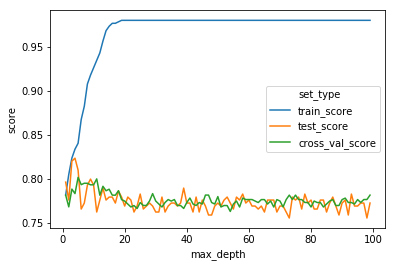

In [24]:
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score', 'test_score', 'cross_val_score'], 
                           var_name="set_type", value_name = "score")
sns.lineplot(x="max_depth", y = "score", hue = "set_type", data = scores_data_long)

In [25]:
scores_data_long.query('set_type == "cross_val_score"').head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781857
199,2,cross_val_score,0.768553
200,3,cross_val_score,0.788678
201,4,cross_val_score,0.783580
202,5,cross_val_score,0.801984
203,6,cross_val_score,0.793693
204,7,cross_val_score,0.795317
205,8,cross_val_score,0.795261
206,9,cross_val_score,0.793537
207,10,cross_val_score,0.793551


***Мы видим, что максимальный кроссвалидационный score достигается при score = 5, т.е. мы его можем сохранить его как лучший классификатор и прогнать на нем те данные, которые предполагается, что классификатор еще не видел.***

In [26]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.8067796610169492

Далее пойдет про использование метода по автоматическому подбору параметров для модели, чтобы максимально автоматизировать процесс. Называется он **'GridSearchCV'**

***Данный метод прогоняет все варианты комбинаций, которые были заданы в аргументе "param_grid", прогоняет их на кроссвалидации с количеством фолдов, которые заданы в аргументе "cv = 5" и покажет тот набор пораметров, которые показывают максимальный результат. В контексте оценки результата по умолчанию стоит "accuracy", можно поставить другие параметры (типа F-меры или ROC-AUC, или что-то другое) в аргументе "scoring"***

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
clf = tree.DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'],
             'max_depth': range(1, 30)}
grid_search_cv_clf = GridSearchCV(clf, param_grid = parameters, cv = 5)
grid_search_cv_clf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 5}

А потом можно **сохранить лучший классификатор**, который помог определить *GridSearchCV( )* в отдельный классификатор, чтобы потом его использовать.

In [30]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
best_clf.score(X_test, y_test)

0.8101694915254237

Расчитает **PRECISION** и **RECALL SCORES** по данной модели:

In [32]:
from sklearn.metrics import precision_score
y_pred = best_clf.predict(X_test)
precision_score(y_test, y_pred, average='macro')

0.8072390572390573

In [33]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro')  

0.7954761904761904

На самом деле дерево решений принимает решение об отнесении определенного объекта к опредленному классу на основании полученной вероятности. Но мы сами можем варьировать вероятность, после которой объект нужно относить к тому или иному классу. (*По-умолчанию вероятность отсечки отнесения к тому или другому классу - 0.5*) Об этом ниже:

In [34]:
y_predicted_prob = best_clf.predict_proba(X_test)
y_predicted_prob[:5, :]

array([[0.875     , 0.125     ],
       [0.875     , 0.125     ],
       [0.875     , 0.125     ],
       [0.        , 1.        ],
       [0.49056604, 0.50943396]])

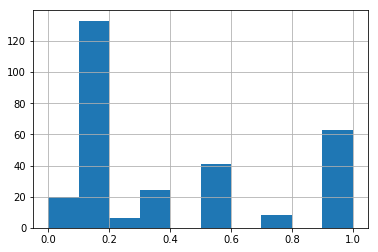

In [35]:
pd.Series(y_predicted_prob[:, 1]).hist()

На гистограмме мы видим, что довольно много значений на рубеже 0.4 или 0.6. Мы хотим относить к классу 1 (выживших) только тех, у которых вероятность выживания больше 80%

Здесь используется функция **np.where( ), которая аналогична ifelse( ) в R.** Когда нужно что-то по какому-то условию поменять на что-то другое.

In [36]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)
y_pred[:20]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

А теперь проверим параметры ***PRECISION и RECALL***, если бы это были предиктнутые значения, то что мы только что сформировали. 
- Высокий precision, низкий recall - если отсечение на 0.8 (когда нам важно, чтобы попадание было точное). 
- Низкий precision, высокий recall - если отсечение сделать на уровне 0.2 (когда нам важно, чтобы все цели были найдены, неважно сколько ресурсов)

Вот таким образом можно варьировать параметры precision и recall.

In [37]:
precision_score(y_test, y_pred)

0.9206349206349206

In [38]:
recall_score(y_test, y_pred)

0.48333333333333334

Какой оптимальный порог отсечения выбрать? Поможет **ROC-кривая**

**ROC-кривая** - график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущих признак *(1 классифицированный как 1, или выживший классифицированный как выживший) (TRUE POSITIVE RATE - TP)* и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущих признак *(0 классифицированный как 1, или умерший классифицированный как выживший) (FALSE POSITIVE RATE - FP)*

**Количественную интерпретацию ROC даёт показатель AUC** (area under ROC curve) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор. При значении 0.5 - непригодность классификатора, потому что данное значение равно случайному угадыванию. При значении меньше 0.5 - классификатор действует с точностью до наоборот.

**ROC-кривая** строится на основе <u>**реальных данных и вероятностей, предсказанных моделью.**</u>

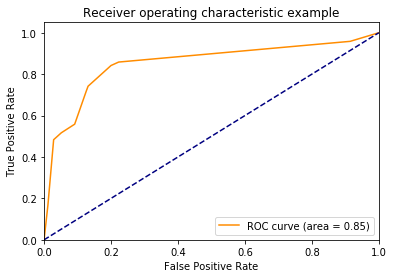

In [39]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

 **RANDOM FOREST**

Попробуем использовать ансамблевую модель Random Forest.

<u>***СУТЬ МЕТОДА:***</u>
Используется несколько деревьев, которые мы задаем в аргументе "n_estimators". Каждому дереву дается определенный сабсет данных (определенное количество переменных (обычно не все) и определенное количество строк (тоже не все)), таким образом каждое дерево на основании данных, что мы дали просчитывает вероятности наступления зависимого события. Потом все вероятности, полученные в результате каждого дерева усредняются и тот набор параметров, который привел к максимальному усредненному значению вероятности - то и будем считать лучшей комбинацией деревьев.

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
parameters = {'n_estimators' : [10, 20, 30],
             'max_depth': [2, 5, 7, 10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv = 5)
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [42]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.8033898305084746

Также можно посмотреть на **важность фичей из всех данных**, что мы давали в random forest.

In [43]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                       'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending = False)

,features,feature_importances
6,Sex_male,0.230951
4,Fare,0.207483
1,Age,0.156133
5,Sex_female,0.147032
0,Pclass,0.109582
2,SibSp,0.054404
3,Parch,0.041004
7,Embarked_C,0.022138
9,Embarked_S,0.019915
8,Embarked_Q,0.011359
